<a href="https://colab.research.google.com/github/rmpbastos/data_science/blob/master/Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Prediction

### How to build a churn prediction model 



---

Building up and keeping a loyal clientele can be challenging for any company, especially when customers are free to choose from a variety of providers within a product category. Furthermore, retaining existing customers is generally more cost-effective than acquiring new ones.

For this reason, evaluating client retention is crucial for business. It is essential to not only measure the level of customer satisfaction but also to measure the amount of clients that stops doing business with a company or service.

**Customer churn**, also known as customer attrition, is the percentage of customers that stopped using a company's service during a particular time period. Keeping churn rates as low as possible is what every business pursuits, and understanding this metrics can assist companies to identify potential churners in time to prevent them from leaving the client base.

In this article, we will build a churn prediction model based on a telecommunication company dataset.


## About the data

The dataset was provided by [IBM Developer Platform](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#) and is available [here](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv). Some information, such as the company name or private client data, were kept anonymous for the sake of confidentiality and will not affect the model's performance.

Let's import the necessary libraries and print the first five rows to start examining the dataset.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import LabelEncoder

%matplotlib inline

# Import data
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [3]:
# set default matplotlib parameters
import matplotlib as mpl

COLOR = '#ababab'
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['grid.color'] = COLOR
mpl.rcParams['grid.alpha'] = 0.1

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


We have a row for each customer and the features' categories are described below:

Demographic customer information

* `gender`
* `SeniorCitizen`
* `Partner`
* `Dependents`

Services that each customer has signed up for

* `PhoneService`
* `MultipleLines`
* `InternetService`
* `OnlineSecurity`
* `OnlineBackup`
* `DeviceProtection`
* `TechSupport`
* `StreamingTV`
* `StreamingMovies`

Customer account information

* `tenure`
* `Contract`
* `PaperlessBilling`
* `PaymentMethod`
* `MonthlyCharges`
* `TotalCharges`

Customers who left within the last month (This is the feature our model is going to predict)

* `Churn`


## Data Analysis

We will start the analysis by taking a look at the size of the dataset and examining the features.

In [5]:
print(f"Rows: ", df.shape[0])
print(f"Columns: ", df.shape[1])

Rows:  7043
Columns:  21


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
# number of unique observations per column
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

Observe that we have 21 features for 7043 clients. Among all features, 3 of them are numerical, 10 are categorical and the remaining can be considered binary.

The feature `customerID` represents a unique value for each row. Eliminating it will help us clean the dataset without spoiling the model.




In [8]:
# eliminate 'customerID'
df.drop('customerID', axis=1, inplace=True)

Also, notice that the variable `TotalCharges` is wrongly classified as a string. 

Before moving further, we need to convert `TotalCharges` to float. However, when doing so the following error is raised: *Unable to parse string " " at position 488*.

Although all features were displayed above as non-null, we need to verify `TotalCharges` for whitespaces counting as strings.

In [9]:
print(f"Cells filled with whitespace in 'TotalCharges' (Before): ", len(df[df['TotalCharges'] == ' ']))

Cells filled with whitespace in 'TotalCharges' (Before):  11


We should deal with these 11 blank fields before converting the whole column to numerical. First, the blank cells will be replaced by null values. In the following step, they will be filled with the median of `TotalCharges`.

In [10]:
# replace whitespaces by null values 
df.loc[df['TotalCharges'] == ' ', 'TotalCharges'] = np.nan
print(f"Cells filled with whitespace in 'TotalCharges' (After): ", len(df[df['TotalCharges'] == ' ']))

Cells filled with whitespace in 'TotalCharges' (After):  0


In [11]:
# replace null values by the median of 'TotalCharges'
TotalCharges_median = df['TotalCharges'].median()
df['TotalCharges'].fillna(TotalCharges_median, inplace=True)

Now we can proceed and convert the `TotalCharges` column to float.

In [12]:
# convert 'TotalCharges' from string to float
df['TotalCharges'] = df['TotalCharges'].astype(float)

Now that we have dealt with `TotalCharges`, let's check some statistical details of the numerical features and see if there is any evidence of outliers.

In [13]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


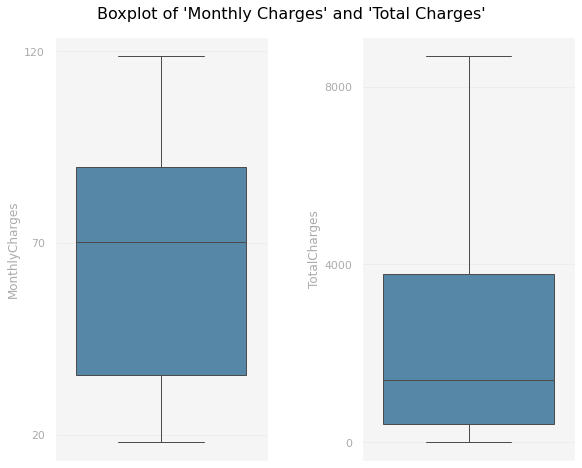

In [14]:
# draw a boxplot to check for outliers
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 7))
fig.suptitle("Boxplot of 'Monthly Charges' and 'Total Charges'")

boxprops = whiskerprops = capprops = medianprops = dict(linewidth=1)

sns.boxplot(df['MonthlyCharges'], orient='v', color='#488ab5', ax=ax[0], 
            boxprops=boxprops, 
            whiskerprops=whiskerprops, 
            capprops=capprops, 
            medianprops=medianprops)
ax[0].set_facecolor('#f5f5f5')
ax[0].set_yticks([20, 70, 120])

sns.boxplot(df['TotalCharges'], orient='v', color='#488ab5', ax=ax[1],
            boxprops=boxprops, 
            whiskerprops=whiskerprops, 
            capprops=capprops, 
            medianprops=medianprops)
ax[1].set_facecolor('#f5f5f5')
ax[1].set_yticks([0, 4000, 8000])

plt.tight_layout(pad=4.0);

At first glance, everything looks ok with our numerical features. We didn't spot any outlier in `MonthlyCharges` nor in `TotalCharges`.

Before starting to apply some feature engineering, let's check the value distribution for our target variable `Churn`.

In [15]:
print(df['Churn'].value_counts())
print('\nTotal Churn Rate: {:.2%}'.format(df[df['Churn'] == 'Yes'].shape[0] / df.shape[0]))

No     5174
Yes    1869
Name: Churn, dtype: int64

Total Churn Rate: 26.54%


We are dealing with an unbalanced dataset. Observe that the churn rate is 26.5%, meaning that the quantity of "No" values is substantially higher than that of "Yes" values.

## Data Preparation

Ok, we have already made some minor adjustments to the dataset, such as eliminating `customerID` and converting `TotalCharges` to numerical.

Now, we are going to perform a closer examination of the features to identify if any further adjustments can be made to improve our machine learning model. Let's check the unique values for the categorical features.

In [16]:
# unique values for each column containing a categorical feature
def unique_values():
  cat_columns = np.unique(df.select_dtypes('object').columns)
  for i in cat_columns:
    print(i, df[i].unique())

unique_values()

Churn ['No' 'Yes']
Contract ['Month-to-month' 'One year' 'Two year']
Dependents ['No' 'Yes']
DeviceProtection ['No' 'Yes' 'No internet service']
InternetService ['DSL' 'Fiber optic' 'No']
MultipleLines ['No phone service' 'No' 'Yes']
OnlineBackup ['Yes' 'No' 'No internet service']
OnlineSecurity ['No' 'Yes' 'No internet service']
PaperlessBilling ['Yes' 'No']
Partner ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
PhoneService ['No' 'Yes']
StreamingMovies ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
gender ['Female' 'Male']


Some of the columns with 3 unique values could be treated as binary. To illustrate, the columns `StreamingTV` and `TechSupport` have values "No", "Yes", and "No internet service". In these cases, "No internet service" could be considered as "No".

In [17]:
# switch 'No inernet service to 'No'
to_binary = ['DeviceProtection', 'OnlineBackup', 'OnlineSecurity', 'StreamingMovies', 'StreamingTV', 'TechSupport']

for i in to_binary:
  df.loc[df[i].isin(['No internet service']), i] = 'No'

Let's check it out to see how the categorical features look like now.

In [18]:
unique_values()

Churn ['No' 'Yes']
Contract ['Month-to-month' 'One year' 'Two year']
Dependents ['No' 'Yes']
DeviceProtection ['No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
MultipleLines ['No phone service' 'No' 'Yes']
OnlineBackup ['Yes' 'No']
OnlineSecurity ['No' 'Yes']
PaperlessBilling ['Yes' 'No']
Partner ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
PhoneService ['No' 'Yes']
StreamingMovies ['No' 'Yes']
StreamingTV ['No' 'Yes']
TechSupport ['No' 'Yes']
gender ['Female' 'Male']


As an example, let's plot graphs to see the churn distribution for some of the features.

First, we need to convert `Churn` values to numerical. 

In [19]:
df.loc[df['Churn'] == 'No','Churn'] = 0 
df.loc[df['Churn'] == 'Yes','Churn'] = 1
df['Churn'] = df['Churn'].astype(int)

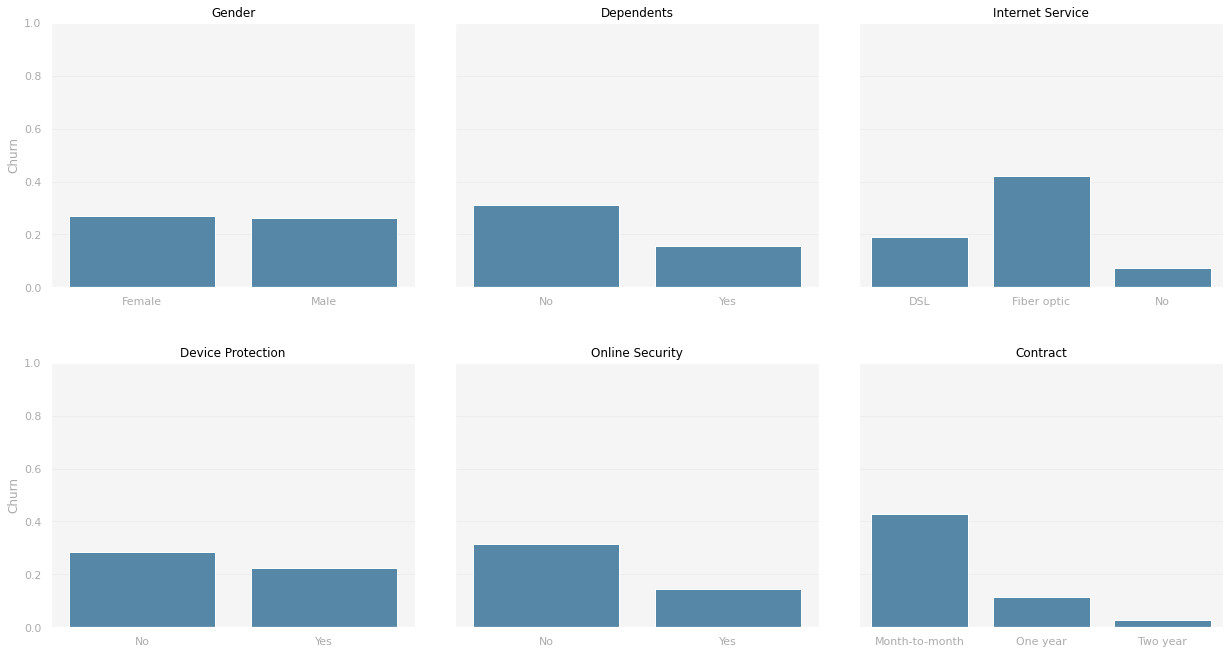

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10))

sns.barplot(df['gender'], df['Churn'], color='#488ab5', ci=None, ax=ax[0][0])
ax[0][0].set_facecolor('#f5f5f5')
ax[0][0].set_ylim(0,1)
ax[0][0].set_xlabel(None)
ax[0][0].set_title('Gender')

sns.barplot(df['Dependents'], df['Churn'], color='#488ab5', ci=None, ax=ax[0][1])
ax[0][1].set_facecolor('#f5f5f5')
ax[0][1].tick_params(labelleft=False)
ax[0][1].set_ylim(0,1)
ax[0][1].set_ylabel(None)
ax[0][1].set_xlabel(None)
ax[0][1].set_title('Dependents')

sns.barplot(df['InternetService'], df['Churn'], color='#488ab5', ci=None, ax=ax[0][2])
ax[0][2].set_facecolor('#f5f5f5')
ax[0][2].tick_params(labelleft=False)
ax[0][2].set_ylim(0,1)
ax[0][2].set_ylabel(None)
ax[0][2].set_xlabel(None)
ax[0][2].set_title('Internet Service')

sns.barplot(df['DeviceProtection'], df['Churn'], color='#488ab5', ci=None, ax=ax[1][0])
ax[1][0].set_facecolor('#f5f5f5')
ax[1][0].set_ylim(0,1)
ax[1][0].set_xlabel(None)
ax[1][0].set_title('Device Protection')

sns.barplot(df['OnlineSecurity'], df['Churn'], color='#488ab5', ci=None, ax=ax[1][1])
ax[1][1].set_facecolor('#f5f5f5')
ax[1][1].tick_params(labelleft=False)
ax[1][1].set_ylim(0,1)
ax[1][1].set_ylabel(None)
ax[1][1].set_xlabel(None)
ax[1][1].set_title('Online Security')

sns.barplot(df['Contract'], df['Churn'], color='#488ab5', ci=None, ax=ax[1][2])
ax[1][2].set_facecolor('#f5f5f5')
ax[1][2].tick_params(labelleft=False)
ax[1][2].set_ylim(0,1)
ax[1][2].set_ylabel(None)
ax[1][2].set_xlabel(None)
ax[1][2].set_title('Contract')

plt.tight_layout(pad=4.0)

Looking at the example above, we can interpret that Gender probably won't be a meaningful variable to the model, as the churn rate is quite similar for both male and female customers. On the other hand, clients with dependents are less prone to stop doing business with the company.

As for the internet service, customers with fiber optic plans are more likely to quit. Their churn rate is more than double that of DSL and no internet users.

Turning to protection services, clients with device protection and online security plans are more likely to maintain their contracts.

Lastly, the type of contract might be a valuable feature for the model. Notice that the churn rate for month-to-month contracts is considerably higher than that of one year and two year contracts.

Considering that most Machine Learning algorithms work better with numerical inputs, we'll preprocess our data using the following techniques to convert categorical features into numerical values:

* `LabelEncoder` for binary
* `get_dummies` for other categorical variables

In [21]:
# list of binary variables, except 'Churn'
bin_var = [col for col in df.columns if len(df[col].unique()) == 2 and col != 'Churn']

# list of categorical variables
cat_var = [col for col in df.select_dtypes(['object']).columns.tolist() if col not in bin_var]

# apply Label Encoding for binaries
le = LabelEncoder()
for col in bin_var:
  df[col] = le.fit_transform(df[col])

# apply get_dummies for categorical
df = pd.get_dummies(df, columns=cat_var)

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,1,0,0,0,0,1,29.85,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,1,0,1,0,0,0,0,56.95,1889.50,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,1,0,0,0,0,1,53.85,108.15,1,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,1,0,1,1,0,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,0,0,0,0,0,0,1,70.70,151.65,1,1,0,0,0,1,0,1,0,0,0,0,1,0


Now that we have our features preprocessed, the data is ready for the machine learning model.

#Machine Learning Models

The first thing we need to do is splitting the data into training and test sets.

In [22]:
# feature matrix
X = df.drop('Churn', axis=1)
# target vector
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y)

Remember that we are dealing with an unbalanced dataset, as we determined a few steps above. 

To manage the situation, we'll standardize the features of the training set using `StardardScaler` and then apply `RandomUnderSampler`, which is a "way to balance the data by randomly selecting a subset of data for the targeted classes", according to the [official documentaion](https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html#controlled-under-sampling).

In [23]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Now that the data is standardized and balanced, the following models will be used and we'll determine which one shows the better results:

* SVC (Support Vector Classifier)
* Logistic Regression
* XGBoost

To evaluate the effectiveness of these models, we could use `Precision` or `Recall`. Precision will give us the proportion of positive identifications that were indeed correct, while recall will determine the proportion of real positives that was correctly identified.

Considering the problem we are trying to solve, `Recall` will be more suitable for this study, as the objective here is to identify the maximum number of clients that are actually prone to stop doing business with the company, even if some "non-churners" are wrongly identify as "churners". That is to say, in our case, it is better to pursue the smaller number of False Negatives possible.

In [24]:
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()

model = []
cross_val = []
recall = []
for i in (svc, lr, xgb):
  model.append(i.__class__.__name__)
  cross_val.append(cross_validate(i, X_train_rus, y_train_rus, scoring='recall'))
  
for d in range(len(cross_val)):
  recall.append(cross_val[d]['test_score'].mean())

We used **Cross Validation** to get better results. Instead of simply splitting the data into a train and test set, the `cross_validate` method splits our training data into *k* number of *Folds*, making a better use of the data. In our case, we performed a 5-fold cross validation, as we let the default *k* value.

In [25]:
model_recall = pd.DataFrame
pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
SVC,0.772340
LogisticRegression,0.792908
XGBClassifier,0.787234


Notice that all 3 models provided similar results, with a recall rate of about 80%. We'll now tune some hyperparameters on the models to see if we can achieve higher recall values. The method utilized here is `GridSearchCV`, which will search over specified parameter values for each estimator. Each model has a variety of parameters that can be tuned, but we are only adjusting those with more potential to impact the prediction (specified in the `param_grid` parameter), while the remainder can be left to their default values.

In [40]:
# Support Vector Classifier
# parameters to be searched
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

# find the best parameters
grid_search = GridSearchCV(svc, param_grid, scoring='recall')
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.973049645390071 for {'C': 0.0001, 'kernel': 'poly'}


Notice how effective hyperparameter tuning can be. We searched over different values for `C` and `kernel` and we got an increased recall of 97%, for C = 0.0001 and kernel type "poly".

In [41]:
# Logistic Regression
# parameters to be searched
param_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
              'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

#find the best parameters
grid_search = GridSearchCV(lr, param_grid, scoring='recall')
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.8631205673758865 for {'C': 0.0001, 'solver': 'liblinear'}


Turning to the Logistic Regression, we achieved a better recall as well, with 86% for C = 0.0001 and solver = "liblinear".

Finally, let's make some adjustments to the XGBoost estimator. XGBoost is known for being one of the most effective Machine Learning algorithms, due to its great performance on structured and tabular datasets on classification and regression predictive modeling problems. It is highly customizable and counts with a higher range of parameters to be tuned. Let's check it out.

# **GRID SEARCH FOR XGB**

In [31]:
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [28]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [29]:
xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

# USE THE MODELS

### Hyperparameter tunning

Exploratory Analysis

IR CONFERINDO COM O GABARITO

*   **data type .info()**
*   **determine types of features (categorical, numerical)**
*   **plot churn rate by features (gender, partner, phone service, internet service etc)**
*   **do the same for the numerical features**
*   check correlation

Data preparation

*   **exclude uninportant features**
*   **deal with missing data**
*   **deal with outliers**
*   **feature engineering: label encoder for binary, get dummies for categorical with multiple values**
*  **change churn yes, no to 1, 0**
*   **feature scaling: standardization, normalization**

Machine Learning model

*   **models: SVC, Logistic Regression, XGBoost**
*   **cross-validation**
*   determine best parameters with Grid Search
*   determine best feature for each algorithm (feature importance)
*   ensamble (VotingClassifier)
*   determine best model


**APPLY "STORYTELLING WITH DATA" LAYOUT ON GRAPHS** 




#**EXCLUIR A PARTIR DAQUI**

Moving on, for the binary columns, let's convert the stings 'Yes' and 'No' to integers 1 and 0, as we already did for `Churn`.

In [ ]:
to_binary_copy = to_binary.copy()

to_binary_copy.extend(['Dependents', 'PaperlessBilling', 'Partner', 'PhoneService'])

for i in to_binary_copy:
  df.loc[df[i] == 'Yes', i] = 1
  df.loc[df[i] == 'No', i] = 0
  df[i] = df[i].astype(int)

**CHECK CORRELATION AFTER CHANGING SOME CATEGORICAL FEATURES TO BINARY**

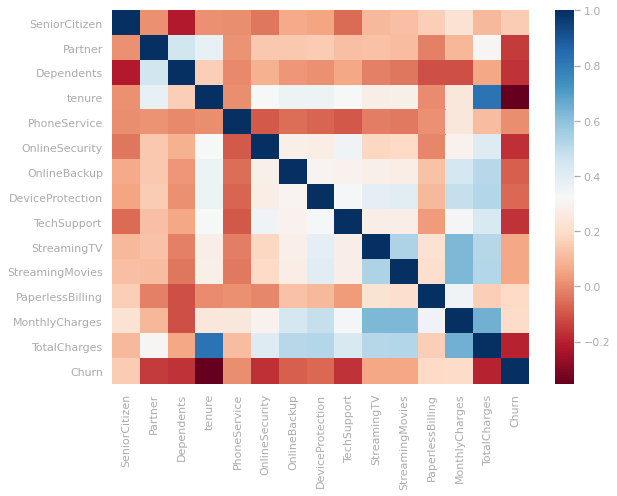

In [ ]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(9, 7))

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="RdBu")
plt.tight_layout()